In [19]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from load_data import DataLoader, MaskedDataGenerator
from CustomMSE import MeanSquaredErrorX
from CustomCall import LoggingCallback

In [3]:
measurements = ['SO2', 'CO', 'H2O', 'HCl', 'HNO3', 'N2O', 'Temperature']
time = [2005001, 2012150]
lon = [-177.5, 177.5]
lat = [-88, 88]

dataloader = DataLoader(measurements=measurements, time_period=time)
X_files, y_files = dataloader.get_files()


train_size = len(X_files) * 6 // 10
validation_size = len(X_files) * 2 // 10
test_size = len(X_files) * 2 // 10

In [4]:

X_train = X_files[:train_size]
y_train = y_files[:train_size]

X_validation = X_files[train_size:train_size + validation_size]
y_validation = y_files[train_size:train_size + validation_size]

X_test = X_files[train_size + validation_size:]
y_test = y_files[train_size + validation_size:]

if not os.path.isdir("saved"):
    os.mkdir("saved")

# Save names of files
save_name = os.path.join('saved', 'first_cnn_model')
checkpoint_save_name = save_name + '_cnn_net.chk'

In [5]:

training_data = MaskedDataGenerator(X_files=X_train, y_files=y_train, batch_size=128, shuffle=True, data_aug=False, normalise=True, normalise_sample=1500)

norm_dict = training_data.get_norm_dict()

validation_data = MaskedDataGenerator(X_files=X_validation, y_files=y_validation, batch_size=128, shuffle=True, data_aug=False, normalise=True, norm_dict=norm_dict)
test_data = MaskedDataGenerator(X_test, y_test, batch_size=128, shuffle=False, data_aug=False, normalise=False)


  0% (0 of 1500) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (5 of 1500) |                       | Elapsed Time: 0:00:00 ETA:   0:00:34
  0% (13 of 1500) |                      | Elapsed Time: 0:00:00 ETA:   0:00:24
  1% (19 of 1500) |                      | Elapsed Time: 0:00:00 ETA:   0:00:24
  1% (24 of 1500) |                      | Elapsed Time: 0:00:00 ETA:   0:00:27
  2% (31 of 1500) |                      | Elapsed Time: 0:00:00 ETA:   0:00:26
  2% (37 of 1500) |                      | Elapsed Time: 0:00:00 ETA:   0:00:27
  2% (44 of 1500) |                      | Elapsed Time: 0:00:00 ETA:   0:00:25
  3% (52 of 1500) |                      | Elapsed Time: 0:00:00 ETA:   0:00:25
  3% (57 of 1500) |                      | Elapsed Time: 0:00:00 ETA:   0:00:24
  4% (60 of 1500) |                      | Elapsed Time: 0:00:01 ETA:   0:00:26
  4% (68 of 1500) |                      | Elapsed Time: 0:00:01 ETA:   0:00:25
  4% (72 of 1500) |#                    

In [6]:

batch_X, batch_y = training_data[0]
input_shape = batch_X.shape[1:]
output_shape = batch_y.shape[1:]
H, W, C = output_shape[0], output_shape[1], output_shape[2]
C = C // 2
output_shape = (H, W, C)

In [7]:
print(output_shape)

(72, 45, 42)


In [8]:
model = models.Sequential()
model.add(layers.Conv2D(32, (4, 4), activation='relu', padding='same', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2DTranspose(128, (3, 3), activation='linear'))
model.add(layers.Conv2DTranspose(128, (6, 3), activation='linear'))

model.add(layers.Conv2DTranspose(64, (8, 8), activation='linear'))
model.add(layers.Conv2DTranspose(64, (10, 10), activation='linear'))
model.add(layers.Conv2DTranspose(64, (10, 5), activation='linear'))
model.add(layers.Conv2DTranspose(64, (10, 5), activation='linear'))
model.add(layers.Conv2DTranspose(32, (10, 5), activation='linear'))
model.add(layers.Conv2DTranspose(32, (5, 5), activation='linear'))
model.add(layers.Conv2DTranspose(42, (10, 5), activation='linear'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=MeanSquaredErrorX())

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 72, 45, 32)        458784    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 22, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 11, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 5, 128)        0

In [9]:

loggingCallback = LoggingCallback(model=model)
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath='current_best',
#     save_weights_only=True,
#     monitor='val_loss',
#     mode='min',
#     save_best_only=True)

history = model.fit(training_data,
        validation_data=validation_data,
        epochs=10)

Epoch 1/10
13/13 [==============================] - 799s 62s/step - loss: 117238.1172 - val_loss: 24256.4551
Epoch 2/10
13/13 [==============================] - 877s 68s/step - loss: 295746.3750 - val_loss: 1154673.5000
Epoch 3/10
13/13 [==============================] - 1028s 83s/step - loss: 4048701.0000 - val_loss: 495225.7188
Epoch 4/10
13/13 [==============================] - 1121s 88s/step - loss: 1716072.5000 - val_loss: 251105.7656
Epoch 5/10
13/13 [==============================] - 1096s 86s/step - loss: 1546920.6250 - val_loss: 202412.8438
Epoch 6/10
13/13 [==============================] - 1139s 89s/step - loss: 100743.2109 - val_loss: 34606.1094
Epoch 7/10
13/13 [==============================] - 1215s 96s/step - loss: 34090.7305 - val_loss: 19349.8984
Epoch 8/10
13/13 [==============================] - 1274s 100s/step - loss: 17219.1816 - val_loss: 13720.4893
Epoch 9/10
13/13 [==============================] - 1315s 103s/step - loss: 12200.0723 - val_loss: 11152.2871
Epoch

In [10]:
batch_X, y_true = test_data[0]
y_pred = model.predict(batch_X)

loss = model.evaluate(test_data)
print(loss)

5/5 [==============================] - 333s 66s/step - loss: 563250332696576.0000
563250332696576.0


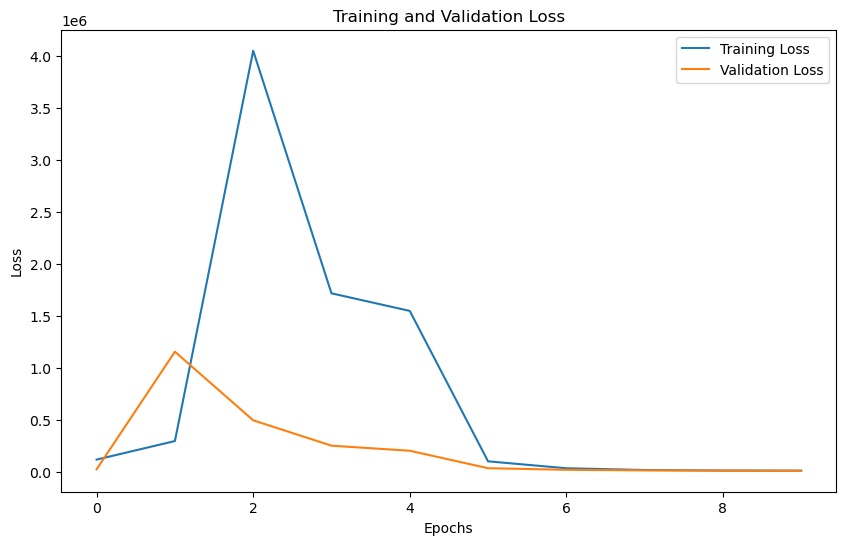

In [20]:

# Extract the loss and validation loss from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training loss and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

72


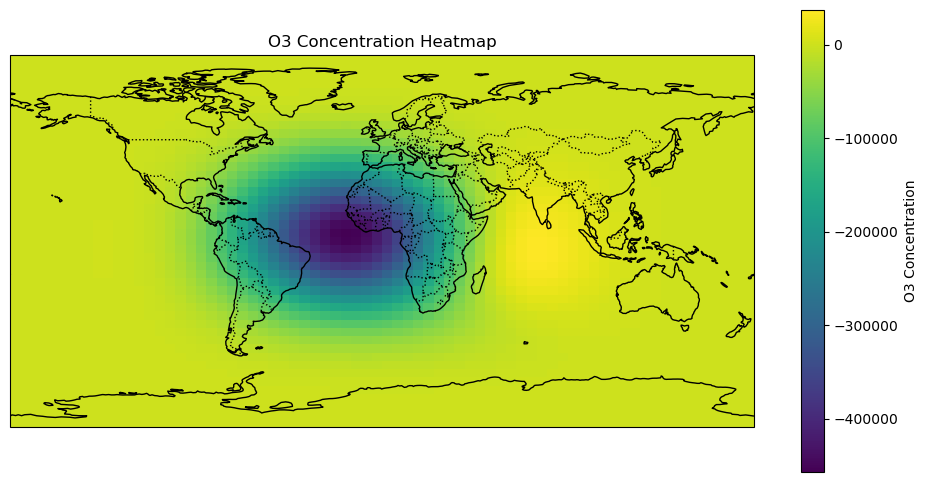

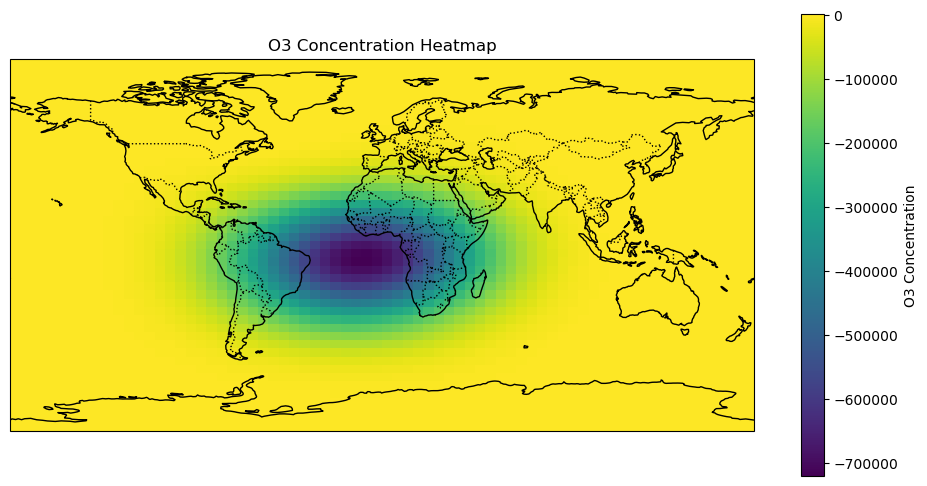

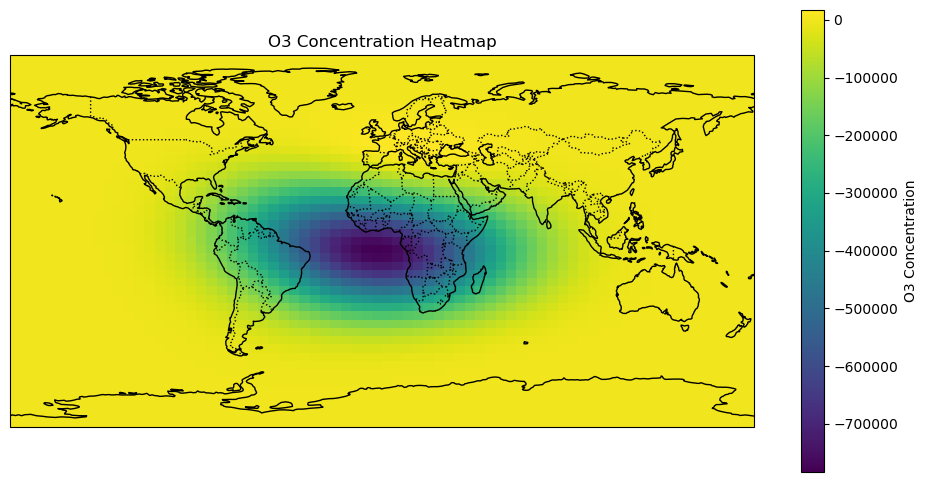

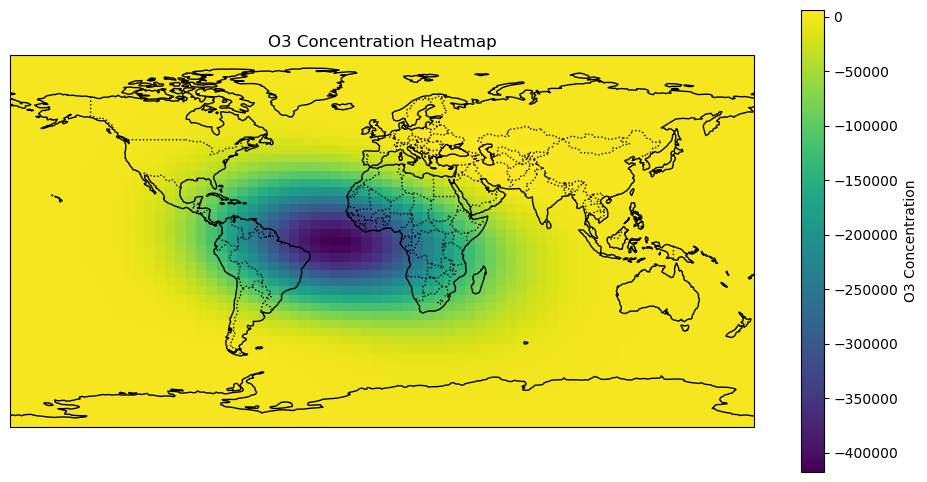

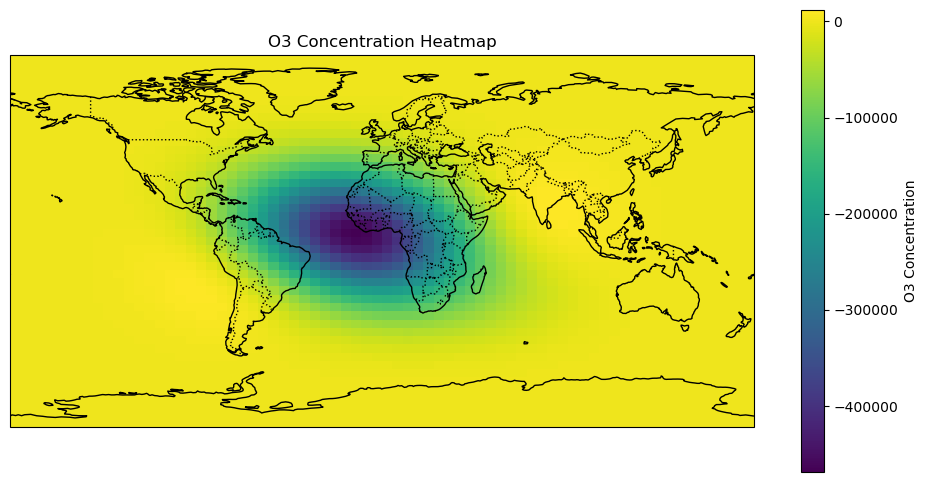

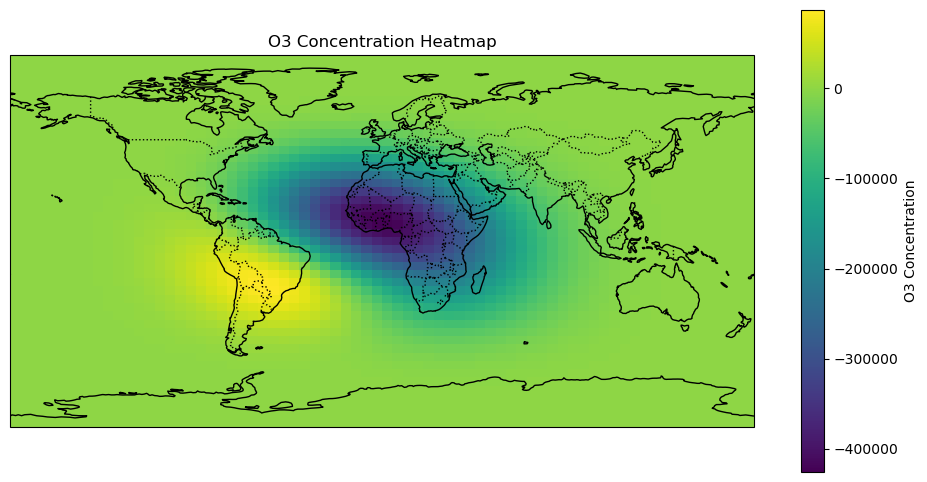

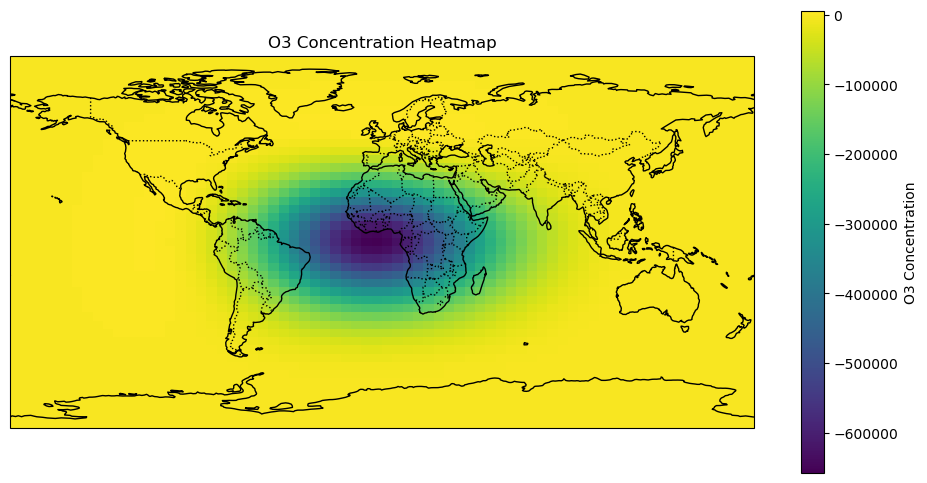

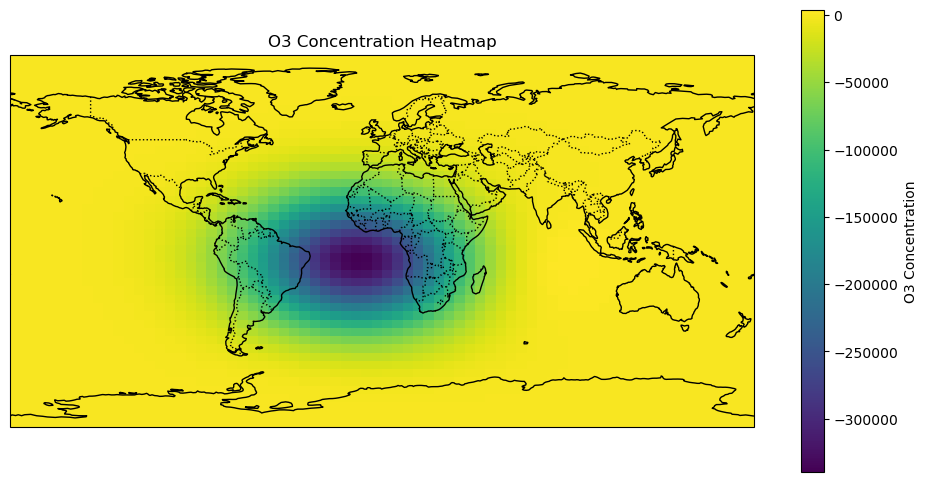

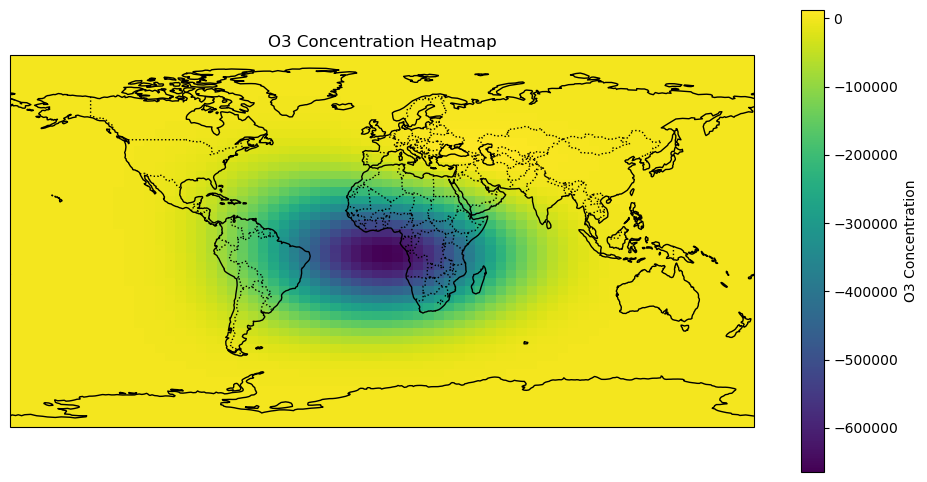

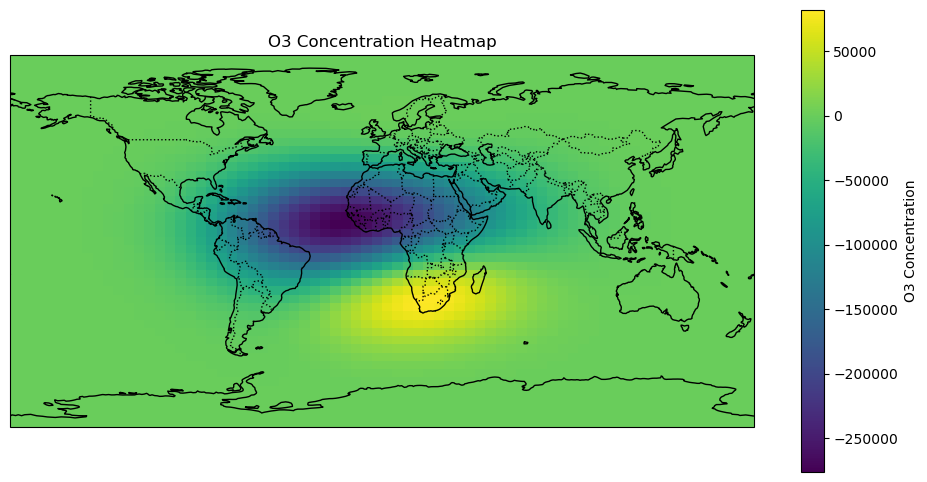

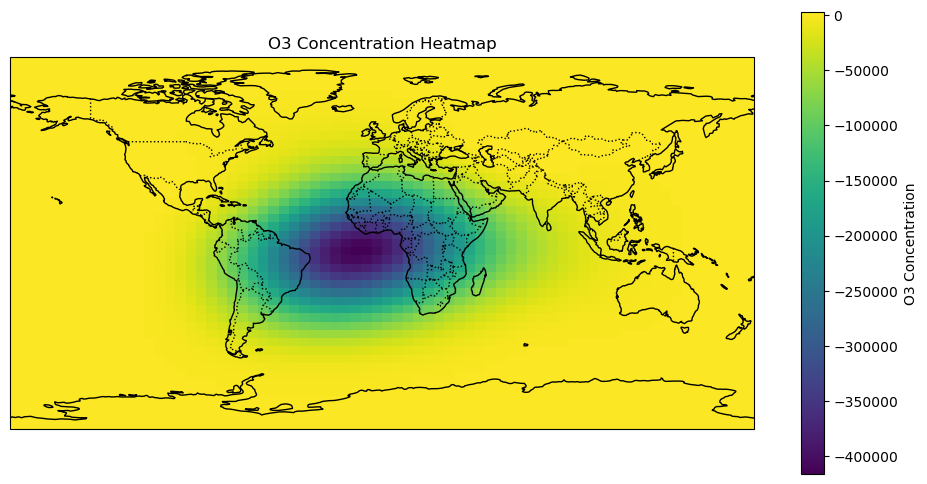

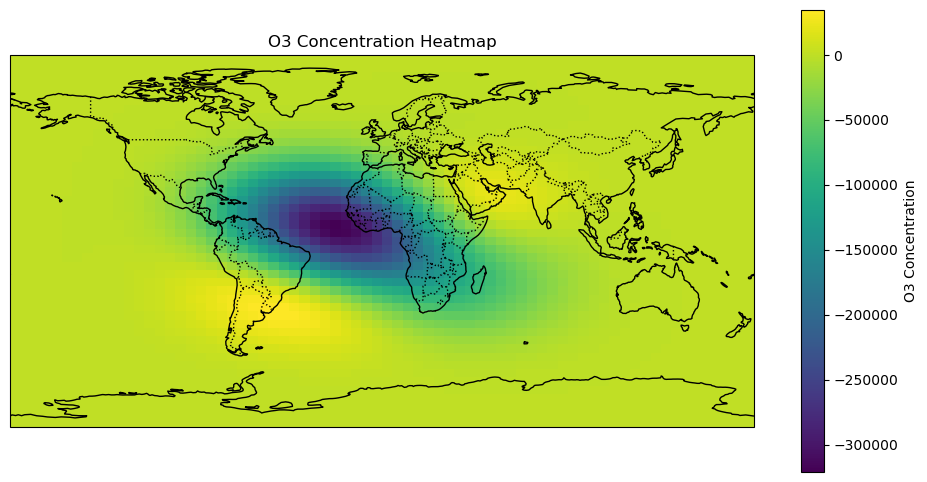

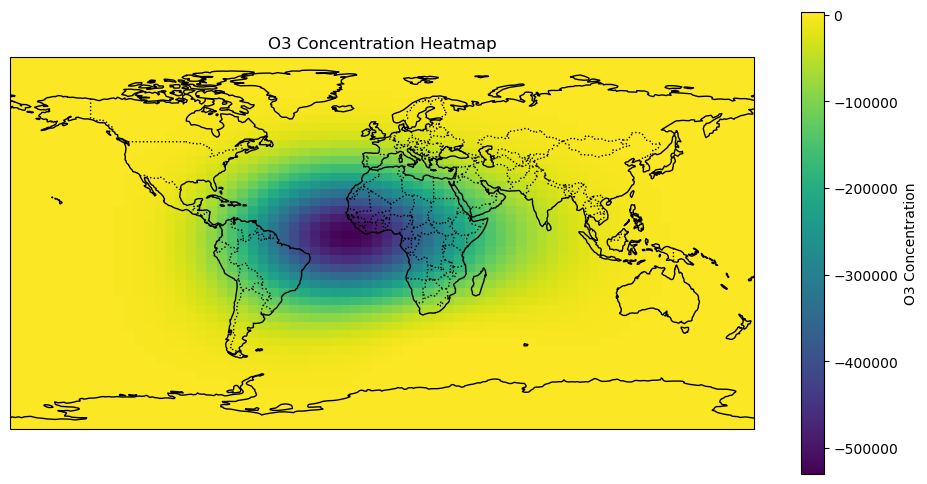

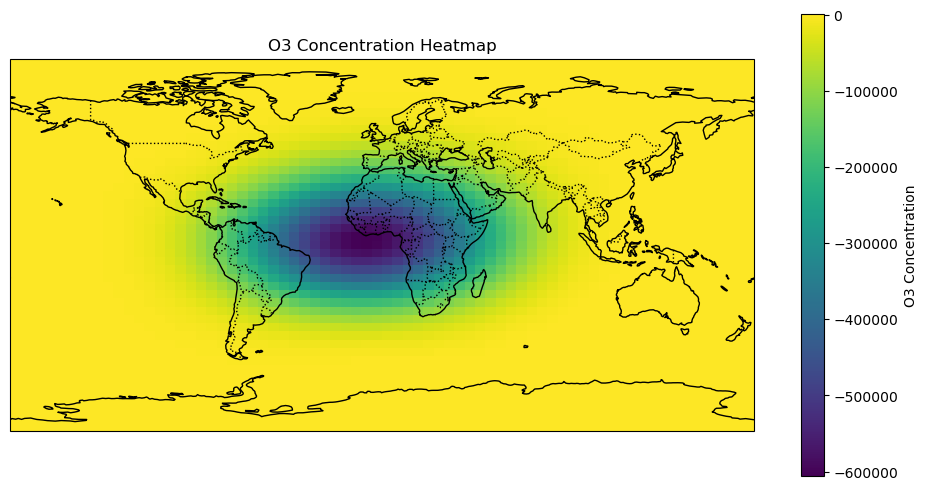

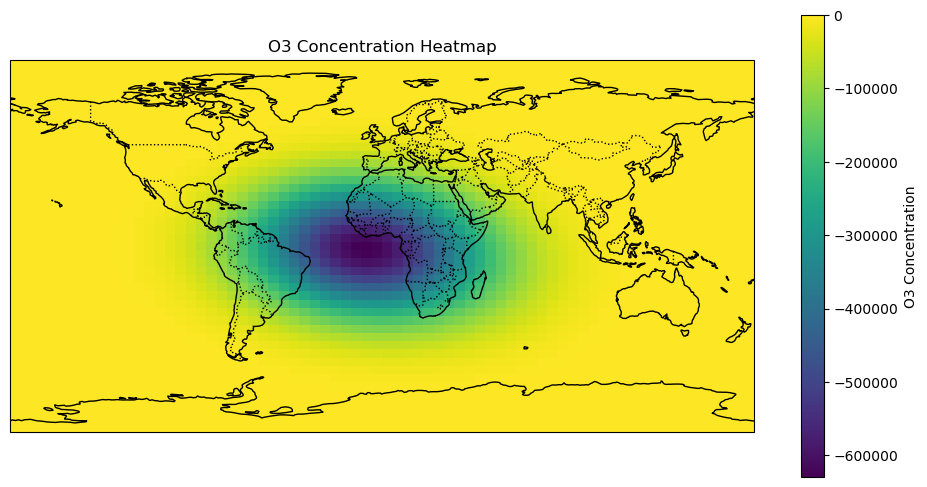

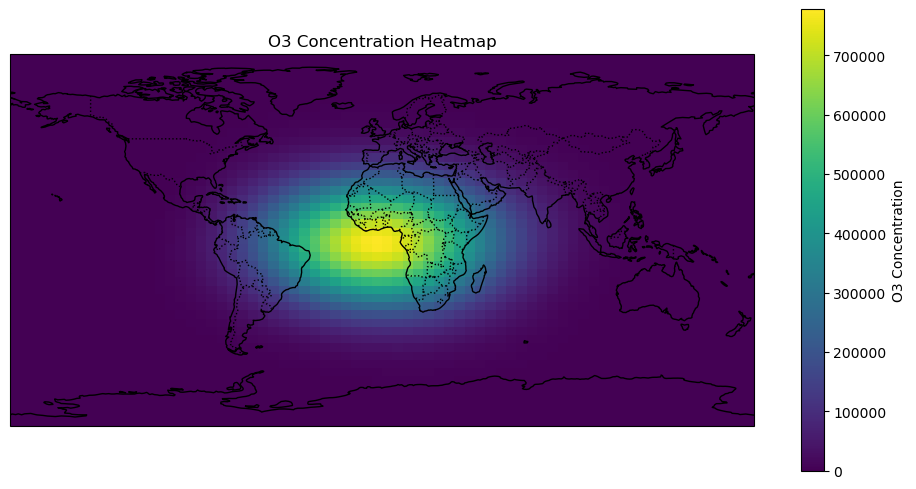

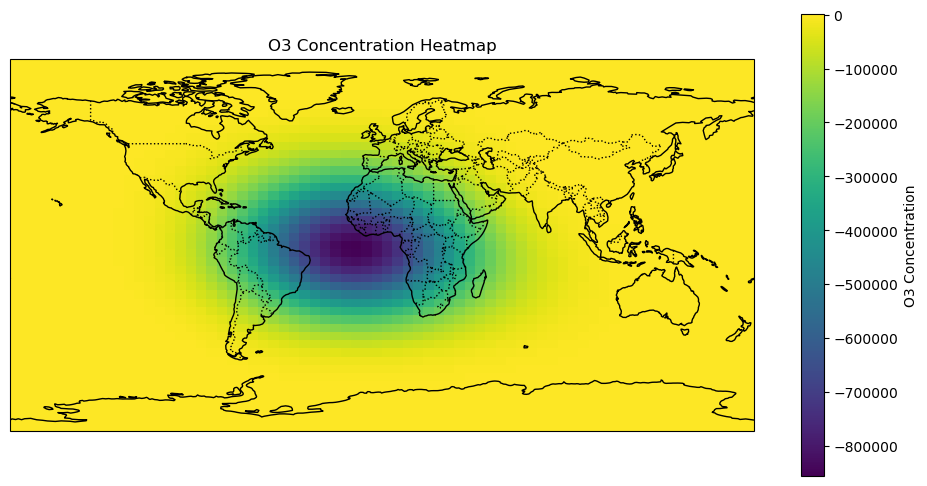

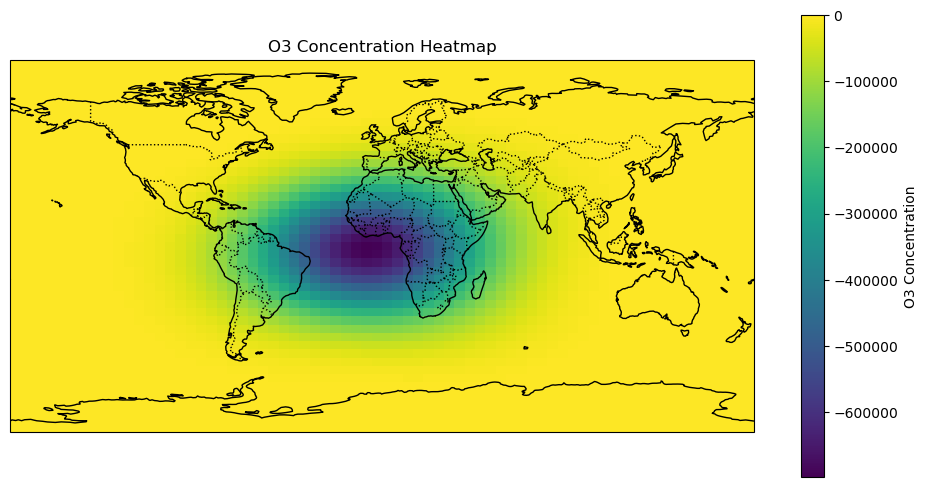

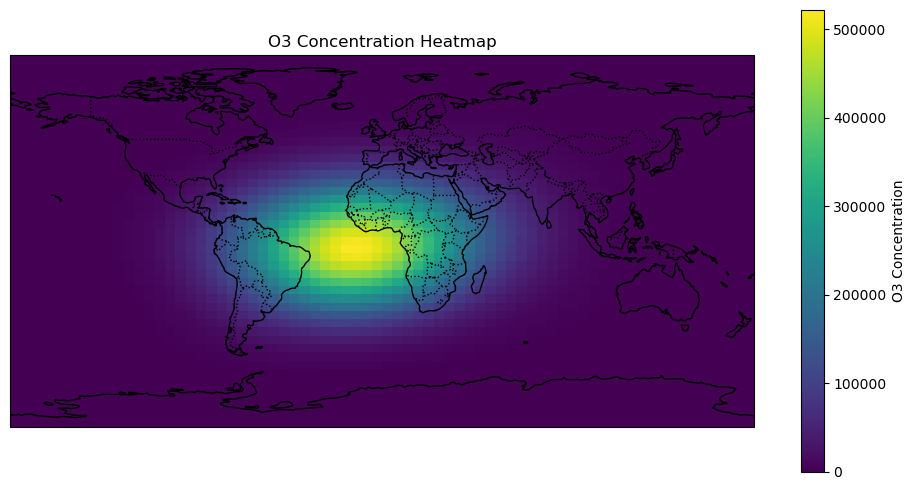

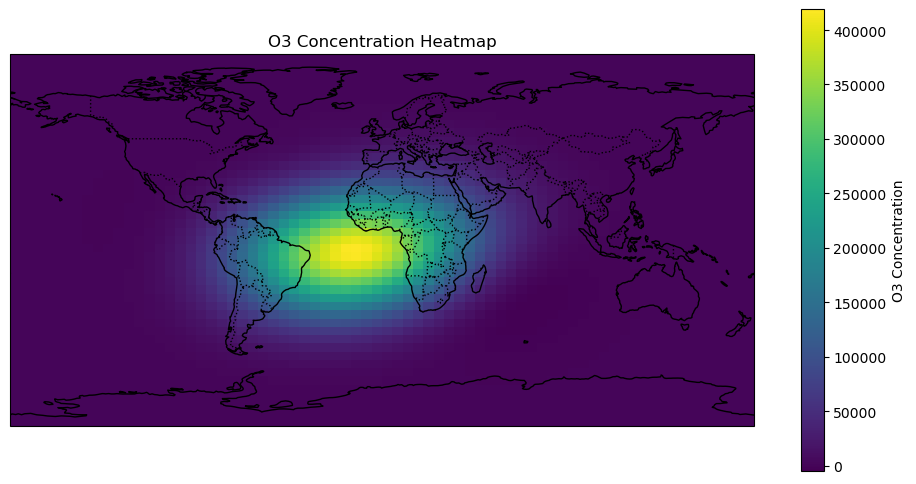

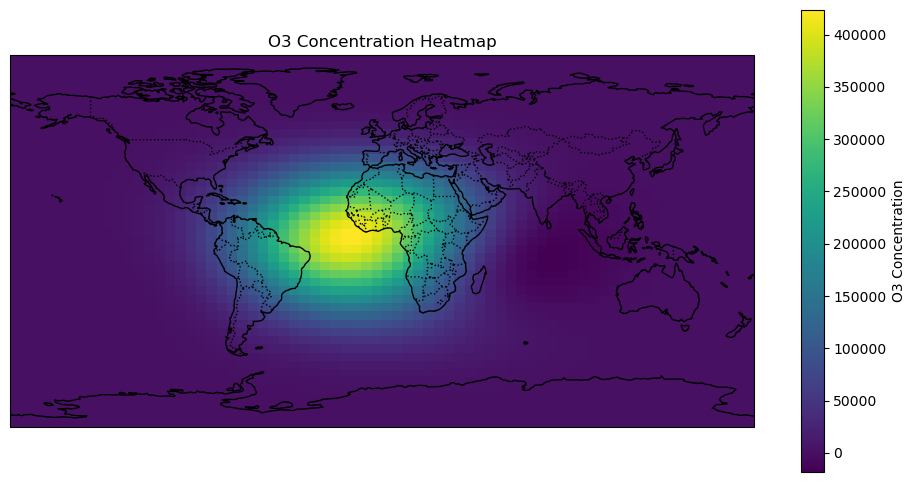

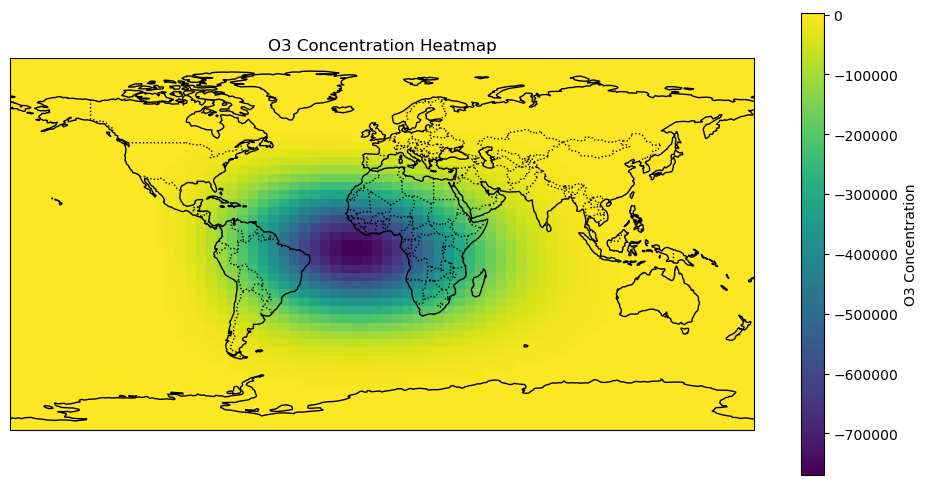

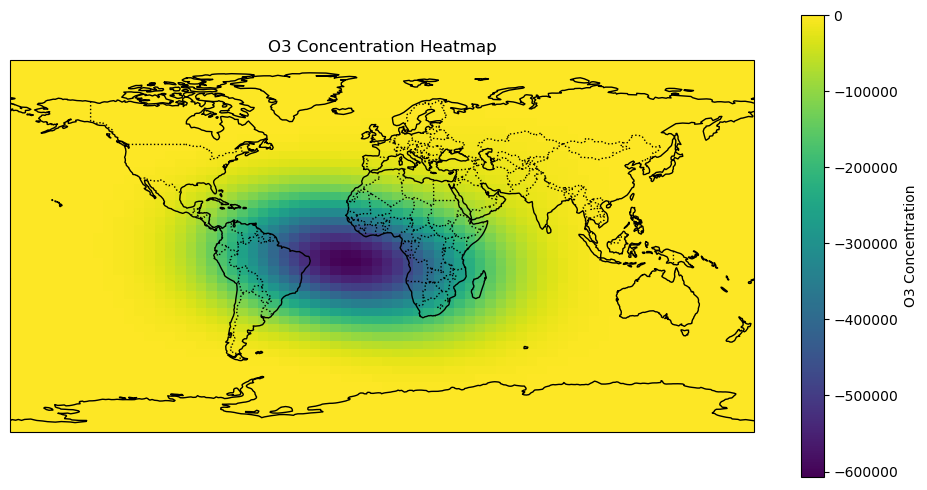

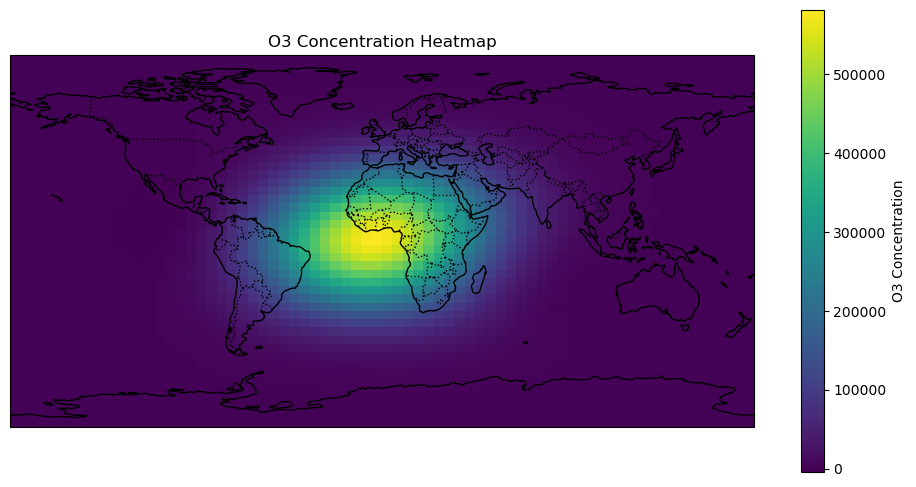

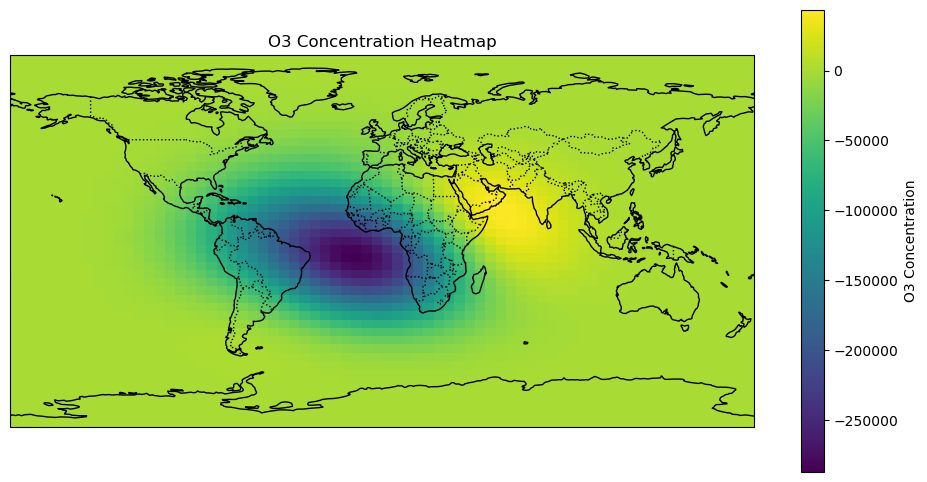

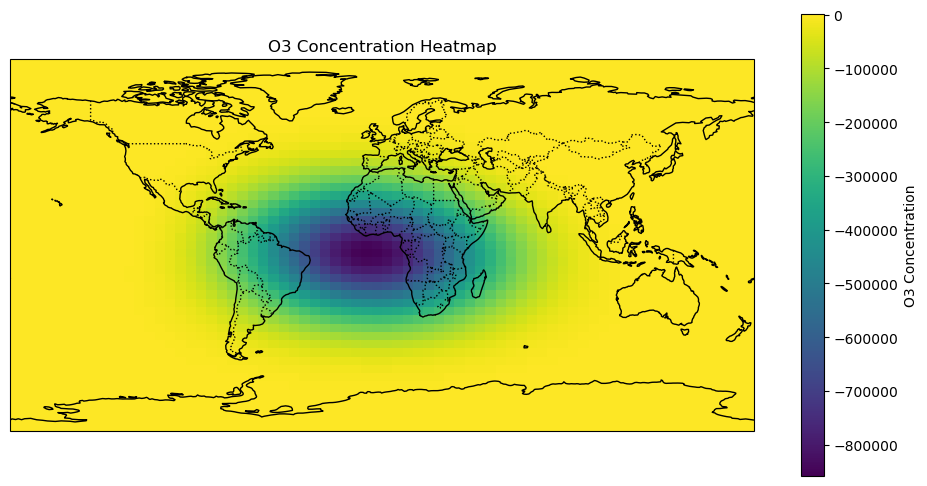

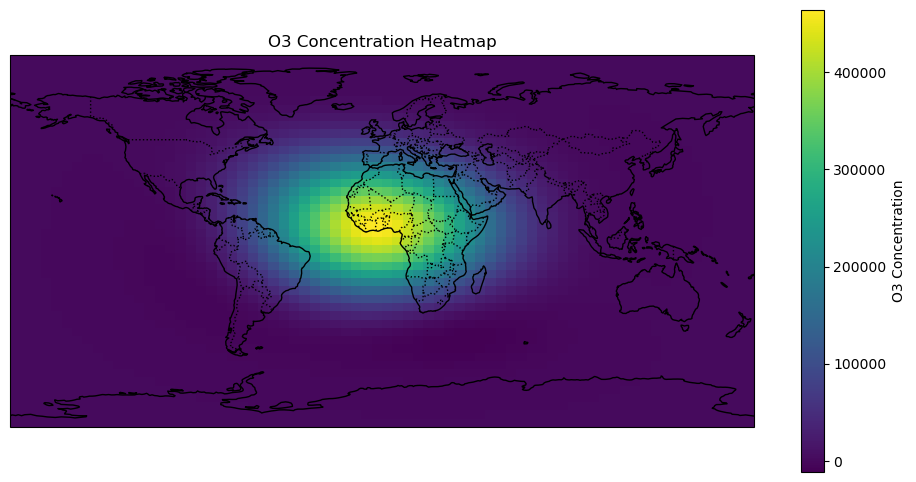

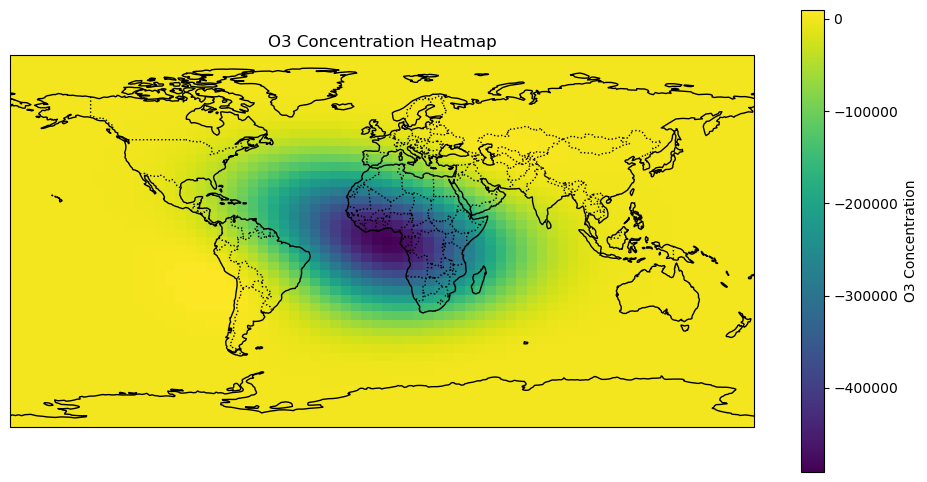

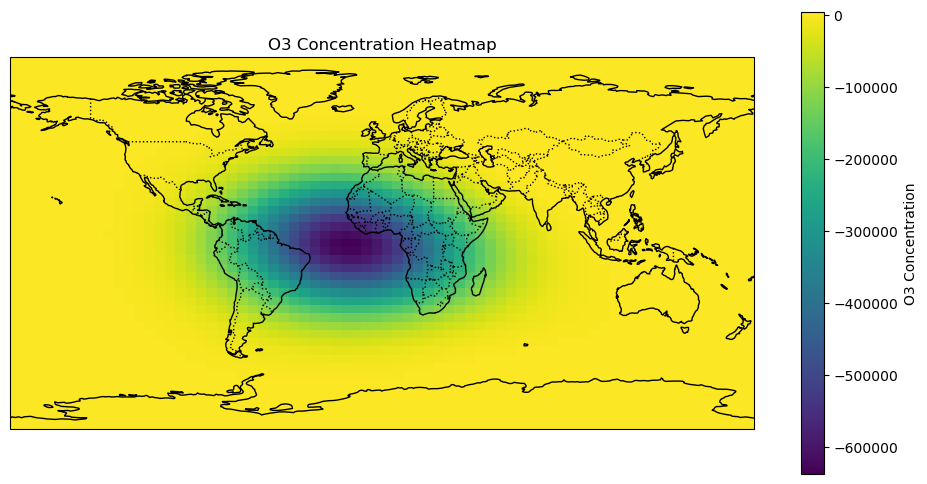

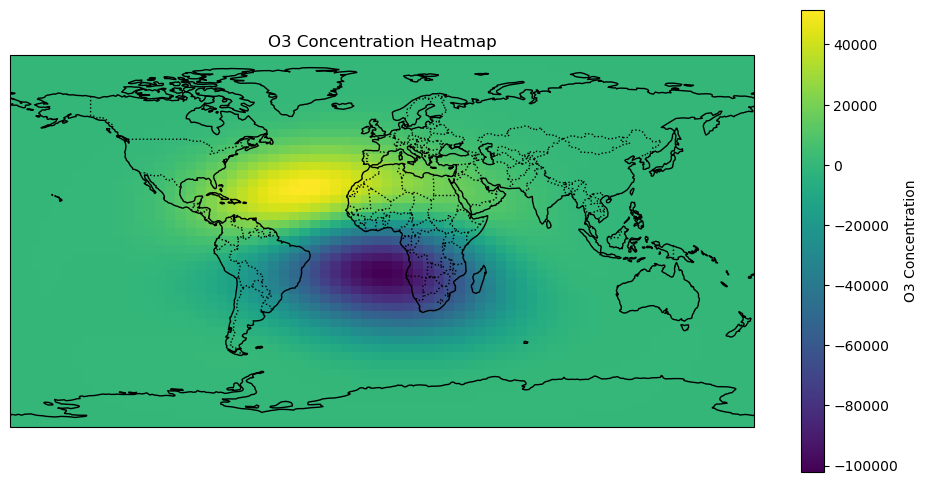

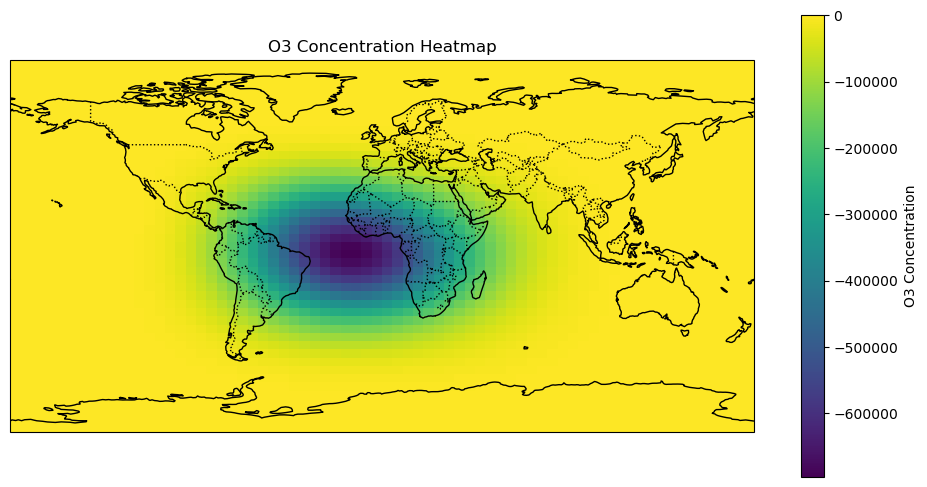

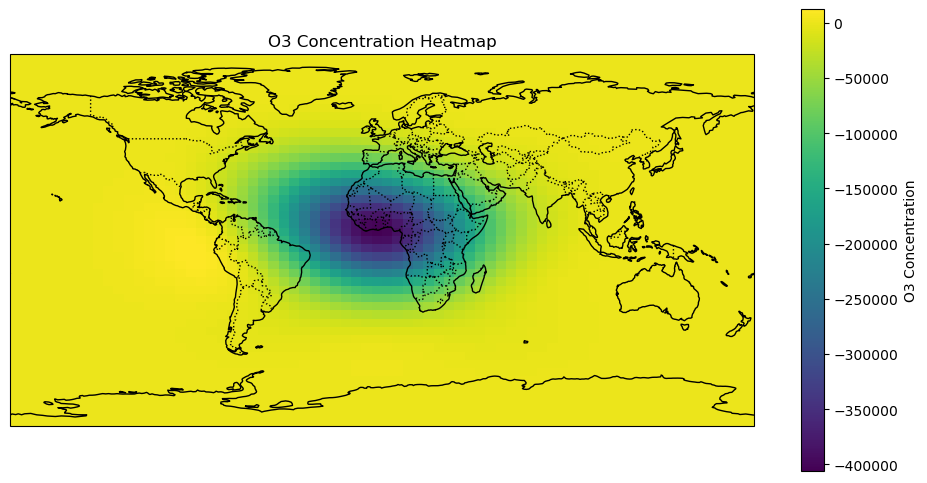

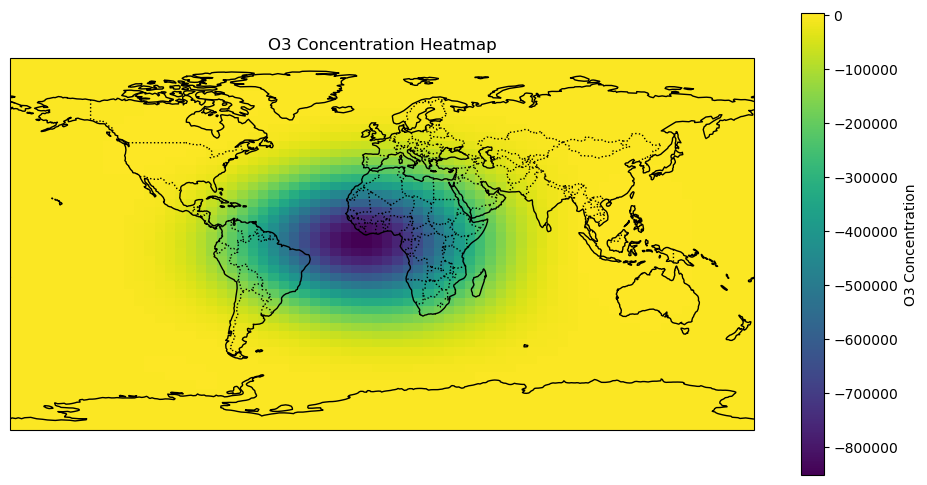

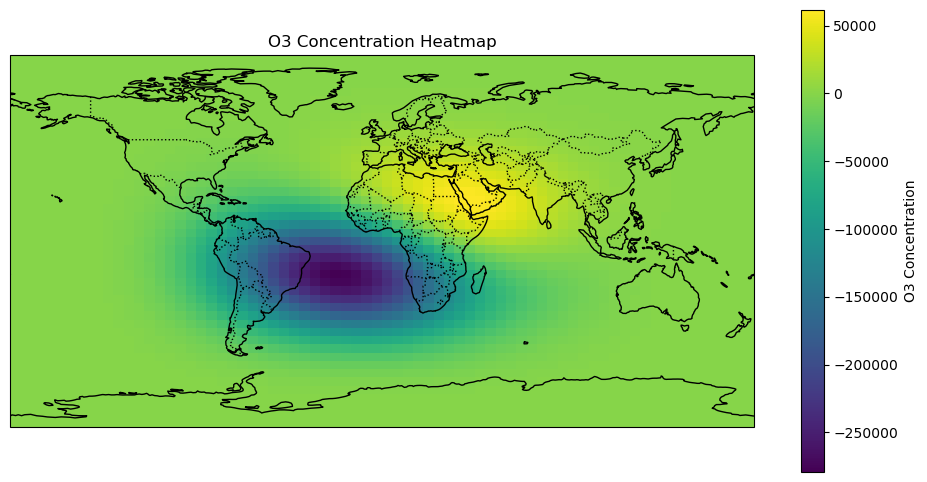

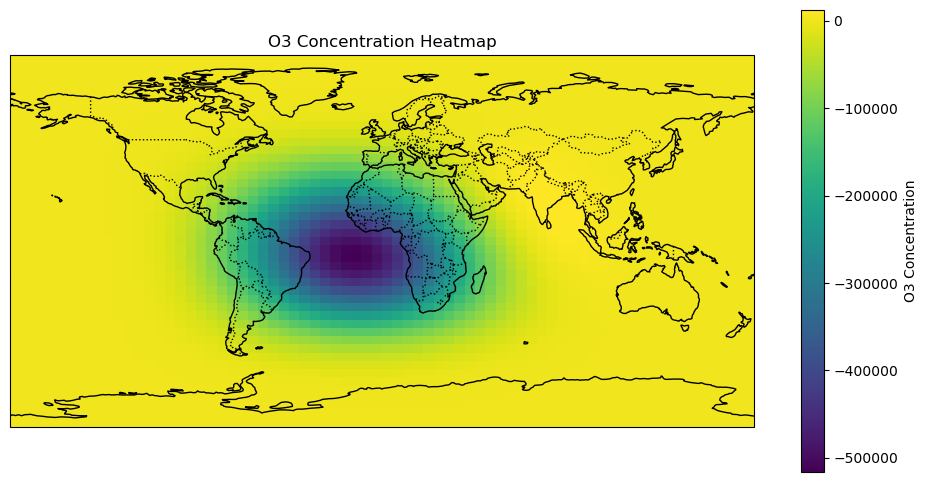

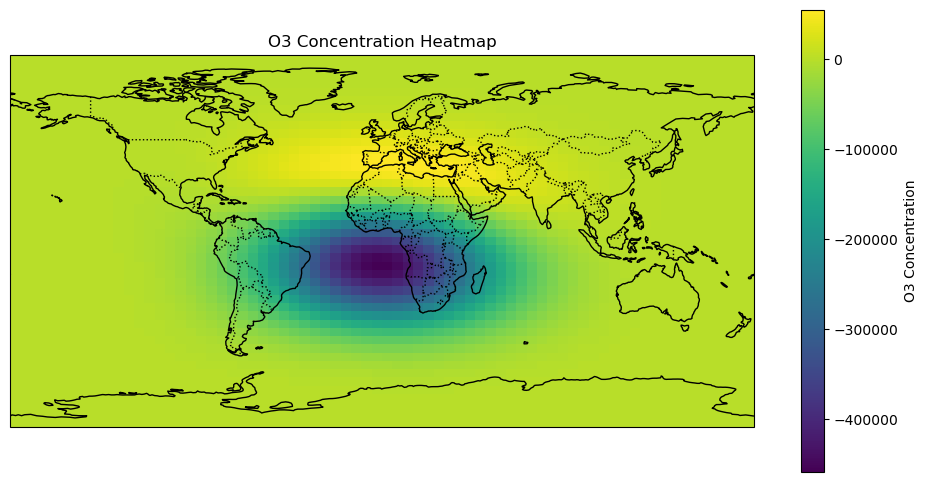

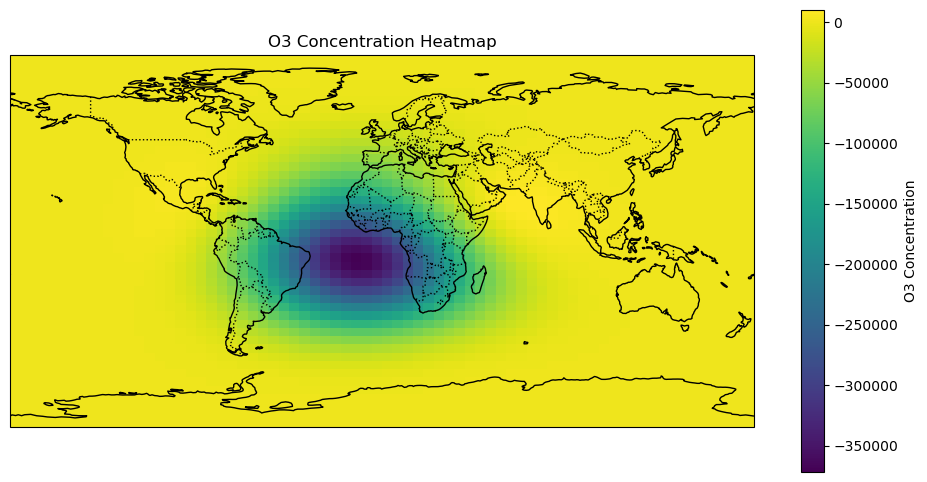

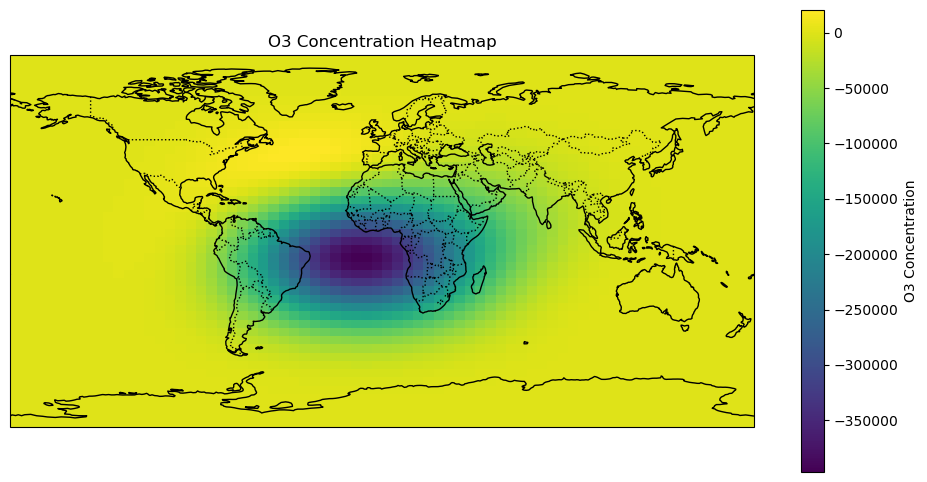

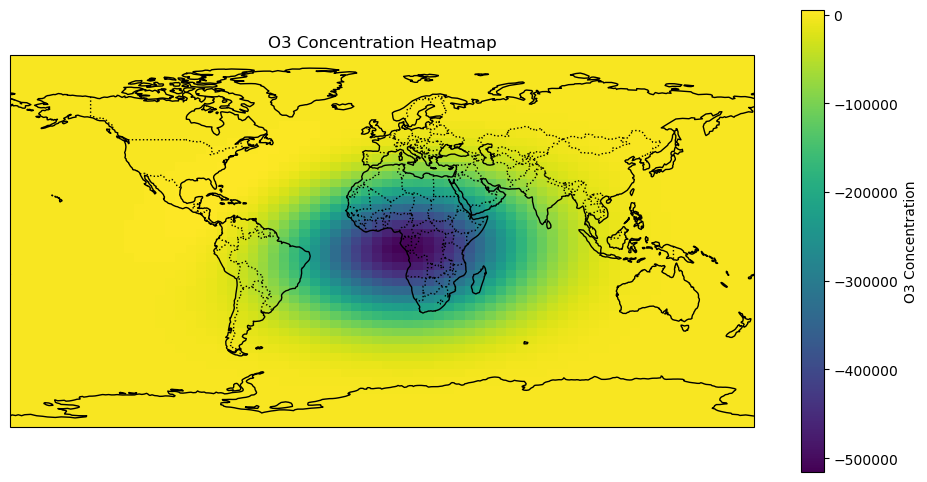

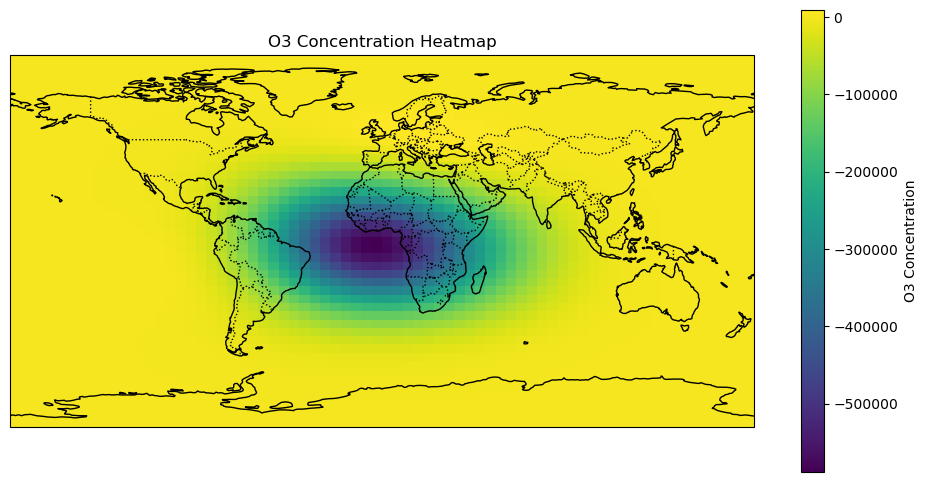

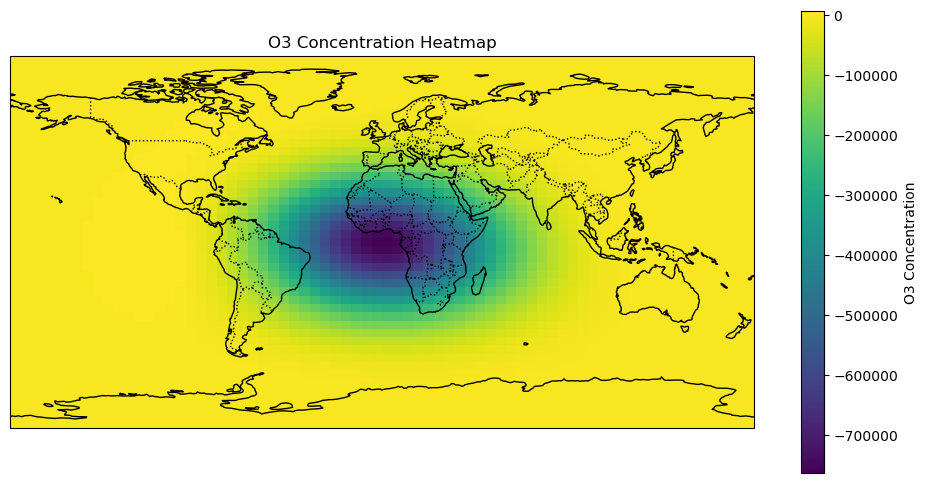

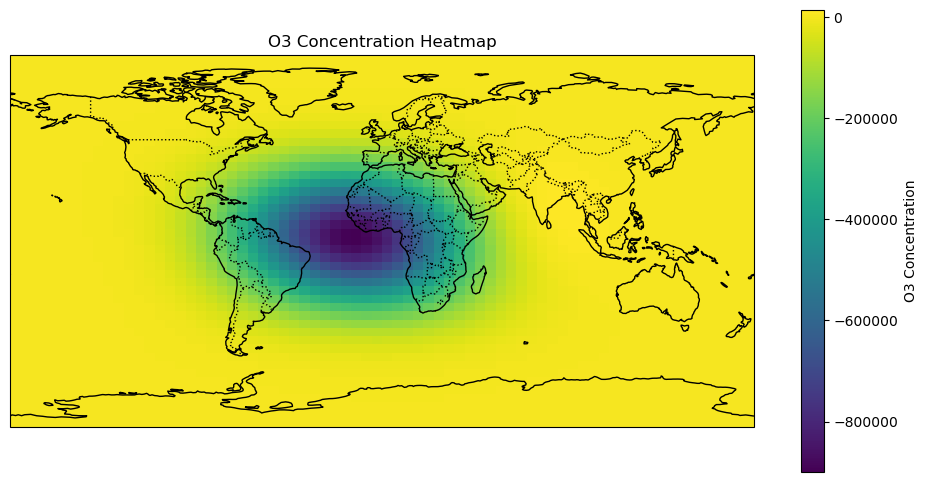

In [26]:
training_data.make_map(y_pred[127], 'O3')

y_true = y_true[:, :, :, 1::2]
training_data.make_map(y_true[127], 'O3')